In [1]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
def plot(file,color="orange",epochs=10):
    with open("results/"+file+"costs.pkl", "rb") as input_file:
        costs = pickle.load(input_file)
    with open("results/"+file+"rews.pkl", "rb") as input_file:
        rewards = pickle.load(input_file)
    
    assert file[:3] in ["ppo","sac","td3"]
    
    if file[:3]=="sac" or file[:3]=="td3":
        avr_train = []
        lowerr_train = []
        upperr_train = []
        avc_train = []
        lowerc_train = []
        upperc_train = []
        avr_test = []
        lowerr_test = []
        upperr_test = []
        avc_test = []
        lowerc_test = []
        upperc_test = []
        n_train = 25
        if len(rewards) == 500:
            n_test = 25
        elif len(rewards) == 350:
            n_test = 10
        elif len(rewards) == 510:
            n_test = 26
            
    else:
        avr_train = []
        lowerr_train = []
        upperr_train = []
        avc_train = []
        lowerc_train = []
        upperc_train = []
        n_train = 25
        n_test = 0
    
    for i in range(epochs):
        avr_train.append(np.mean(rewards[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test]))
        lowerr_train.append(np.mean(rewards[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test])-1.96*
                            np.std(rewards[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test])/np.sqrt(n_train))
        upperr_train.append(np.mean(rewards[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test])
                            +1.96*np.std(rewards[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test])/np.sqrt(n_train))
        avc_train.append(np.mean(costs[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test]))
        lowerc_train.append(np.mean(costs[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test])
                            -1.96*np.std(costs[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test])/np.sqrt(n_train))
        upperc_train.append(np.mean(costs[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test])
                            +1.96*np.std(costs[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test])/np.sqrt(n_train))
        
        
        
        if file[:3]=="sac" or file[:3]=="td3":
            avr_test.append(np.mean(rewards[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)]))
            lowerr_test.append(np.mean(rewards[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)])
                               -1.96*np.std(rewards[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)])/np.sqrt(n_test))
            upperr_test.append(np.mean(rewards[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)])
                               +1.96*np.std(rewards[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)])/np.sqrt(n_test))
            avc_test.append(np.mean(costs[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)]))
            lowerc_test.append(np.mean(costs[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)])
                               -1.96*np.std(costs[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)])/np.sqrt(n_test))
            upperc_test.append(np.mean(costs[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)])
                               +1.96*np.std(costs[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)])/np.sqrt(n_test))

    x = np.arange(epochs)*1000*n_train
    plt.figure(1)
    plt.ylim((-5,30))
    plt.plot(x,avr_train,color=color)
    plt.fill_between(x,lowerr_train,upperr_train,alpha=1/2,color=color, label='_nolegend_')
    #if file[:3]=="sac" or file[:3]=="td3":
    #    plt.plot(x,avr_test,color=color,alpha=0.75, label='_nolegend_')
    #    plt.fill_between(x,lowerr_test,upperr_test,alpha=0.25,color=color, label='_nolegend_')
    
    plt.figure(2)
    plt.ylim((-1,100))
    plt.plot(x,avc_train,color=color)
    plt.fill_between(x,lowerc_train,upperc_train,alpha=1/2,color=color, label='_nolegend_')
    #if file[:3]=="sac" or file[:3]=="td3":
    #    plt.plot(x,avc_test,color=color,alpha=0.75, label='_nolegend_')
    #    plt.fill_between(x,lowerc_test,upperc_test,alpha=0.25,color=color, label='_nolegend_')
    plt.plot(x,np.zeros(10)+25,color="k")


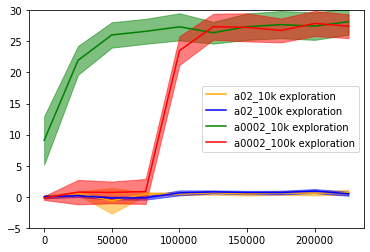

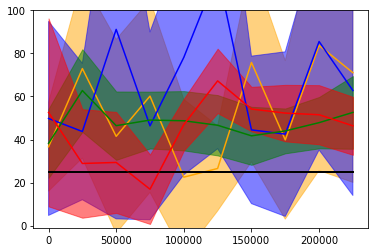

<Figure size 432x288 with 0 Axes>

In [2]:
plot("sac_a02_ss10k")
plot("sac_a02_ss100k","blue")
plot("sac_a0002_ss10k","green")
plot("sac_a0002_ss100k","red")

plt.figure(1)
plt.legend(["a02_10k exploration","a02_100k exploration","a0002_10k exploration","a0002_100k exploration"])
plt.show()
plt.figure(2)
plt.show()

#small SAC-alpha is better. Also, fewer exploration steps?

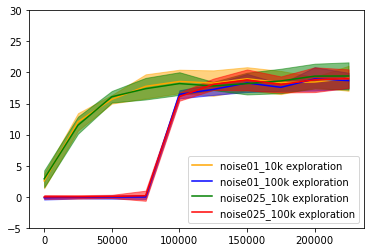

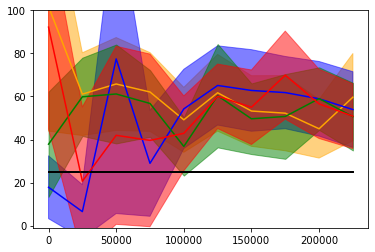

<Figure size 432x288 with 0 Axes>

In [3]:
plot("td3_an01_ss10k")
plot("td3_an01_ss100k","blue")
plot("td3_an025_ss10k","green")
plot("td3_an025_ss100k","red")

plt.figure(1)
plt.legend(["noise01_10k exploration","noise01_100k exploration","noise025_10k exploration","noise025_100k exploration"])
plt.show()
plt.figure(2)
plt.show()

#Less exploration steps seems to be better

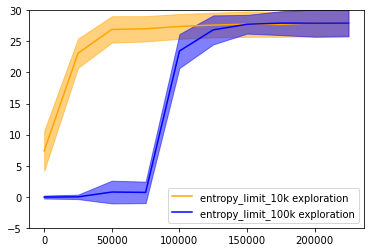

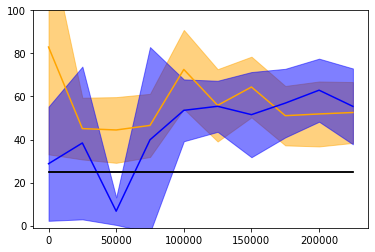

<Figure size 432x288 with 0 Axes>

In [4]:
plot("sac_c_ss10k")
plot("sac_c_ss100k","blue")


plt.figure(1)
plt.legend(["entropy_limit_10k exploration","entropy_limit_100k exploration"])
plt.show()
plt.figure(2)
plt.show()

#Performance very similar to good alphas without any tuning. => Robust?!
#Again fewer exploration steps seem to be better. 

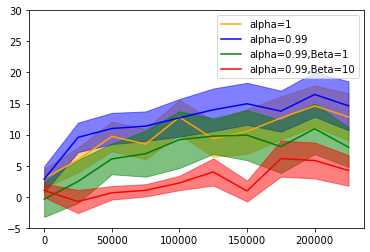

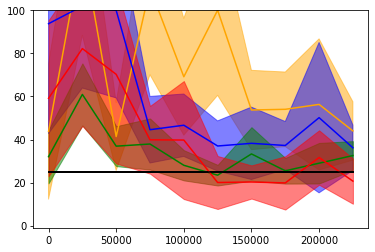

<Figure size 432x288 with 0 Axes>

In [5]:
plot("sac_c_ss10k_m0")
plot("sac_c_ss10k_m001","blue")
plot("sac_c_ss10k_m001_a1","green")
plot("sac_c_ss10k_m001_a10","red")

plt.figure(1)
plt.legend(["alpha=1","alpha=0.99","alpha=0.99,Beta=1","alpha=0.99,Beta=10"])
plt.show()
plt.figure(2)
plt.show()

#High beta seem to be worst wrt to reward but better regarding costs

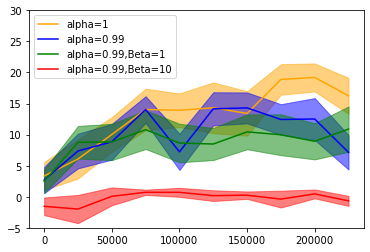

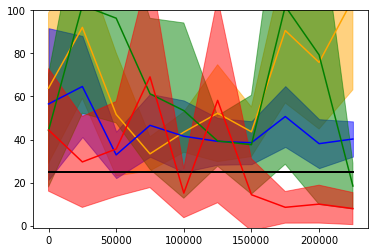

<Figure size 432x288 with 0 Axes>

In [6]:
plot("td3_ss10k_m0")
plot("td3_ss10k_m001","blue")
plot("td3_ss10k_m001_a1","green")
plot("td3_ss10k_m001_a10","red")

plt.figure(1)
plt.legend(["alpha=1","alpha=0.99","alpha=0.99,Beta=1","alpha=0.99,Beta=10"])
plt.show()
plt.figure(2)
plt.show()
#Costs very chaotic, rewards not so stable. Beta = 10 without costs, but also no rewards. 

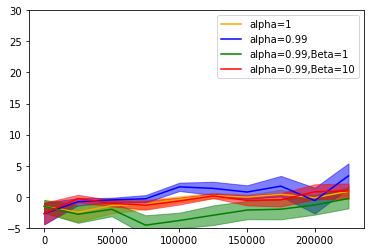

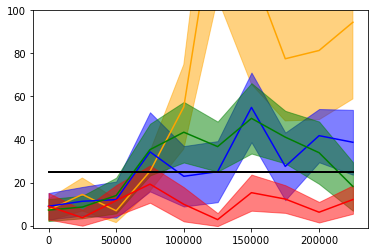

<Figure size 432x288 with 0 Axes>

In [7]:
plot("ppo_m0")
plot("ppo_m001","blue")
plot("ppo_m001_a1","green")
plot("ppo_m001_a10","red")

plt.figure(1)
plt.legend(["alpha=1","alpha=0.99","alpha=0.99,Beta=1","alpha=0.99,Beta=10"])
plt.show()
plt.figure(2)
plt.show()
#Costs ok for large beta. But rewards are pretty small all along

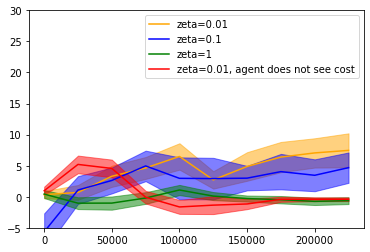

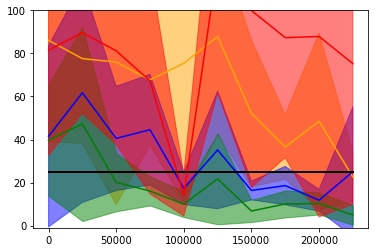

<Figure size 432x288 with 0 Axes>

In [8]:
plot("sac_c_ss10k_m001_a1_c001")
plot("sac_c_ss10k_m001_a1_c01","blue")
plot("sac_c_ss10k_m001_a1_c1","green")
plot("sac_c_ss10k_m001_a1_c001_nocostinfo","red")

plt.figure(1)
plt.legend(["zeta=0.01","zeta=0.1","zeta=1","zeta=0.01, agent does not see cost"])
plt.show()
plt.figure(2)
plt.show()

#Agent that does not see cost is bad in terms of both reward and costs. Roughly, larger zeta means less cost and less reward. 

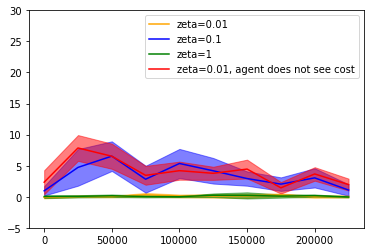

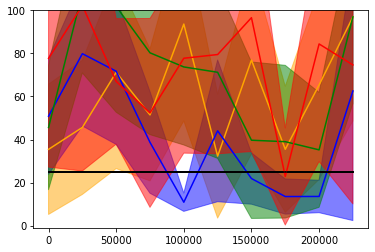

<Figure size 432x288 with 0 Axes>

In [9]:
plot("td3_ss10k_m001_a1_c001")
plot("td3_ss10k_m001_a1_c01","blue")
plot("td3_ss10k_m001_a1_c1","green")
plot("td3_ss10k_m001_a1_c001_nocostinfo","red")

plt.figure(1)
plt.legend(["zeta=0.01","zeta=0.1","zeta=1","zeta=0.01, agent does not see cost"])
plt.show()
plt.figure(2)
plt.show()

#Agent not seeing cost and zeta=0.1 perform best in terms of reward. Others are just chaotic. Overall this does not look like stable learning

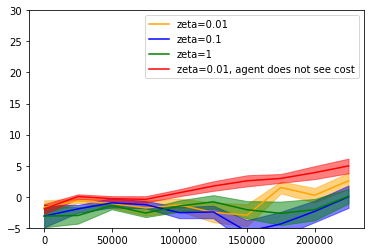

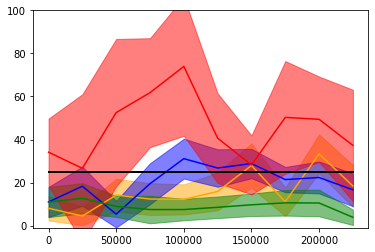

<Figure size 432x288 with 0 Axes>

In [10]:
plot("ppo_m001_a1_c001")
plot("ppo_m001_a1_c01","blue")
plot("ppo_m001_a1_c1","green")
plot("ppo_m001_a1_c001_nocostinfo","red")

plt.figure(1)
plt.legend(["zeta=0.01","zeta=0.1","zeta=1","zeta=0.01, agent does not see cost"])
plt.show()
plt.figure(2)
plt.show()
#Agent not seeing cost with best reward but breaking constraints. Others all seem to be rather good at respecting the constraint.
# But they learn to improve the reward very slowly. 

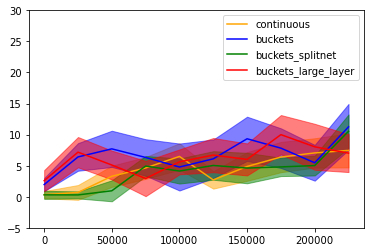

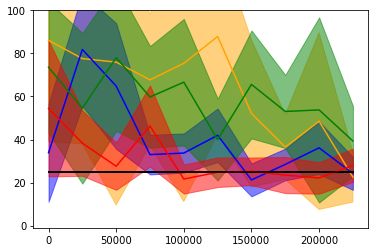

<Figure size 432x288 with 0 Axes>

In [11]:
plot("sac_c_ss10k_m001_a1_c001")
plot("sac_c_ss10k_m001_a1_c001_buckets","blue")
plot("sac_c_ss10k_m001_a1_c001_buckets_splitnet","green")
plot("sac_c_ss10k_m001_a1_c001_buckets_first_layer_512","red")


plt.figure(1)
plt.legend(["continuous","buckets","buckets_splitnet","buckets_large_layer"])
plt.show()
plt.figure(2)
plt.show()
#Weak evidence, but: buckets seem to learn to respect cost more quickly and might learn a bit faster initially.

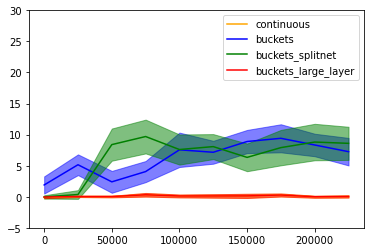

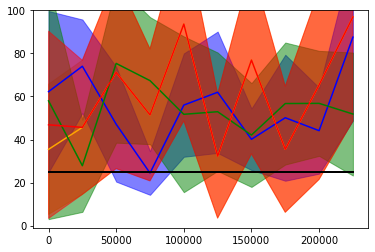

<Figure size 432x288 with 0 Axes>

In [12]:
plot("td3_ss10k_m001_a1_c001")
plot("td3_ss10k_m001_a1_c001_buckets","blue")
plot("td3_ss10k_m001_a1_c001_buckets_splitnet","green")
plot("td3_ss10k_m001_a1_c001_buckets_first_layer_512","red")

    
plt.figure(1)
plt.legend(["continuous","buckets","buckets_splitnet","buckets_large_layer"])
plt.show()
plt.figure(2)
plt.show()

#Nothing seems to learn to respect the constraint. Buckets might be better in terms of reward, but this might just be random fluctuation. 

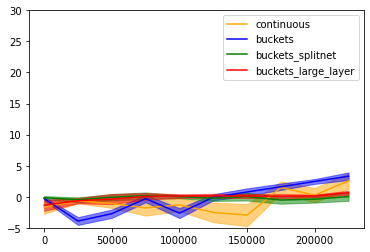

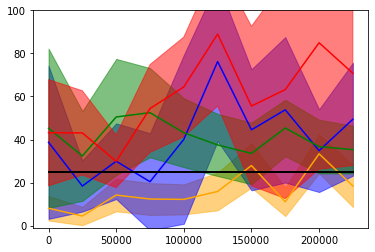

<Figure size 432x288 with 0 Axes>

In [13]:
plot("ppo_m001_a1_c001")
plot("ppo_m001_a1_c001_buckets","blue")
plot("ppo_m001_a1_c001_buckets_splitnet","green")
plot("ppo_m001_a1_c001_buckets_first_layer_512","red")


plt.figure(1)
plt.legend(["continuous","buckets","buckets_splitnet","buckets_large_layer"])
plt.show()
plt.figure(2)
plt.show()
#Buckets seems slightly better in terms of reward, continuous might be better in terms of cost (but not super clear...)

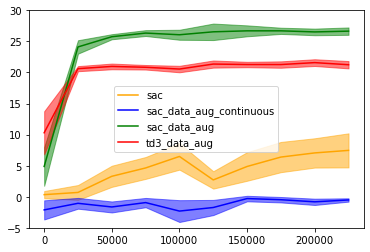

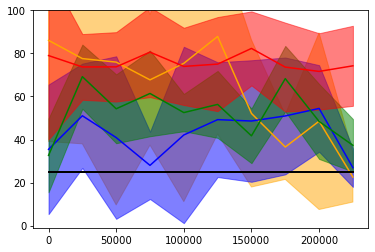

<Figure size 432x288 with 0 Axes>

In [14]:
plot("sac_c_ss10k_m001_a1_c001")
plot("sac_c_ss10k_m001_a1_c001_data_aug_nobuckets","blue")
plot("sac_c_ss10k_m001_a1_c001_data_aug","green")
plot("td3_ss10k_m001_a1_c001_data_aug","red")

plt.figure(1)
plt.legend(["sac","sac_data_aug_continuous","sac_data_aug","td3_data_aug"])
plt.show()
plt.figure(2)
plt.show()
#Data augmenations seems to learn a lot quicker intially, but we don't have strong evidence that it manages to reduce the costs...
#

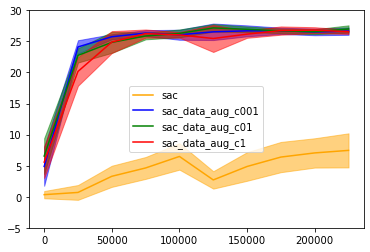

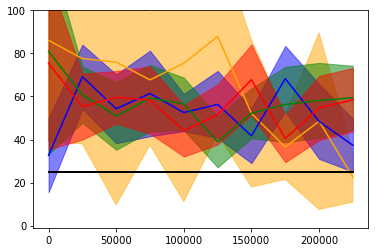

<Figure size 432x288 with 0 Axes>

In [16]:
plot("sac_c_ss10k_m001_a1_c001")
plot("sac_c_ss10k_m001_a1_c001_data_aug","blue")
plot("sac_c_ss10k_m001_a1_c01_data_aug","green")
plot("sac_c_ss10k_m001_a1_c1_data_aug","red")

plt.figure(1)
plt.legend(["sac","sac_data_aug_c001","sac_data_aug_c01","sac_data_aug_c1"])
plt.show()
plt.figure(2)
plt.show()

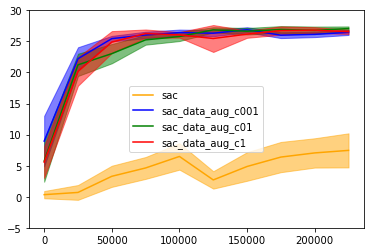

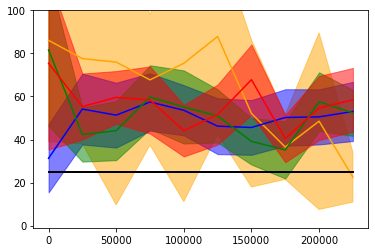

<Figure size 432x288 with 0 Axes>

In [17]:
plot("sac_c_ss10k_m001_a1_c001")
plot("sac_c_ss10k_m001_a10_data_aug","blue")
plot( "sac_c_ss10k_m001_a0_c01_data_aug","green")
plot("sac_c_ss10k_m001_a1_c1_data_aug","red")

plt.figure(1)
plt.legend(["sac","sac_data_aug_a10_c0","sac_data_aug_a10_c001","sac_data_aug_a0_c01"])
plt.show()
plt.figure(2)
plt.show()